# **Stroke Prediction Model**

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('./train_strokes.csv')
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [3]:
# uniform column name format
df.columns = df.columns.str.lower()

# check for duplicate data based on ['id']
df.duplicated('id').sum()

0

In [4]:
# feature ['id'] not needed for analysis
df.drop(['id'], axis=1, inplace=True)

# check null data
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [5]:
# differentiatle numerical and categorical variables
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = df.columns.drop(numeric_cols)

# check unique values of categorical variables
for col in df[categorical_cols]:
    print(f'{col} : {df[col].unique()}')

gender : ['Male' 'Female' 'Other']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
smoking_status : [nan 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [6]:
# check distribution of target variable ['stroke']
print(df.stroke.value_counts(), 
      df.stroke.value_counts(normalize=True)*100, sep='\n\n')

stroke
0    42617
1      783
Name: count, dtype: int64

stroke
0    98.195853
1     1.804147
Name: proportion, dtype: float64


## Data Visualization

### Stroke by Age, Average Glucose Level, and BMI

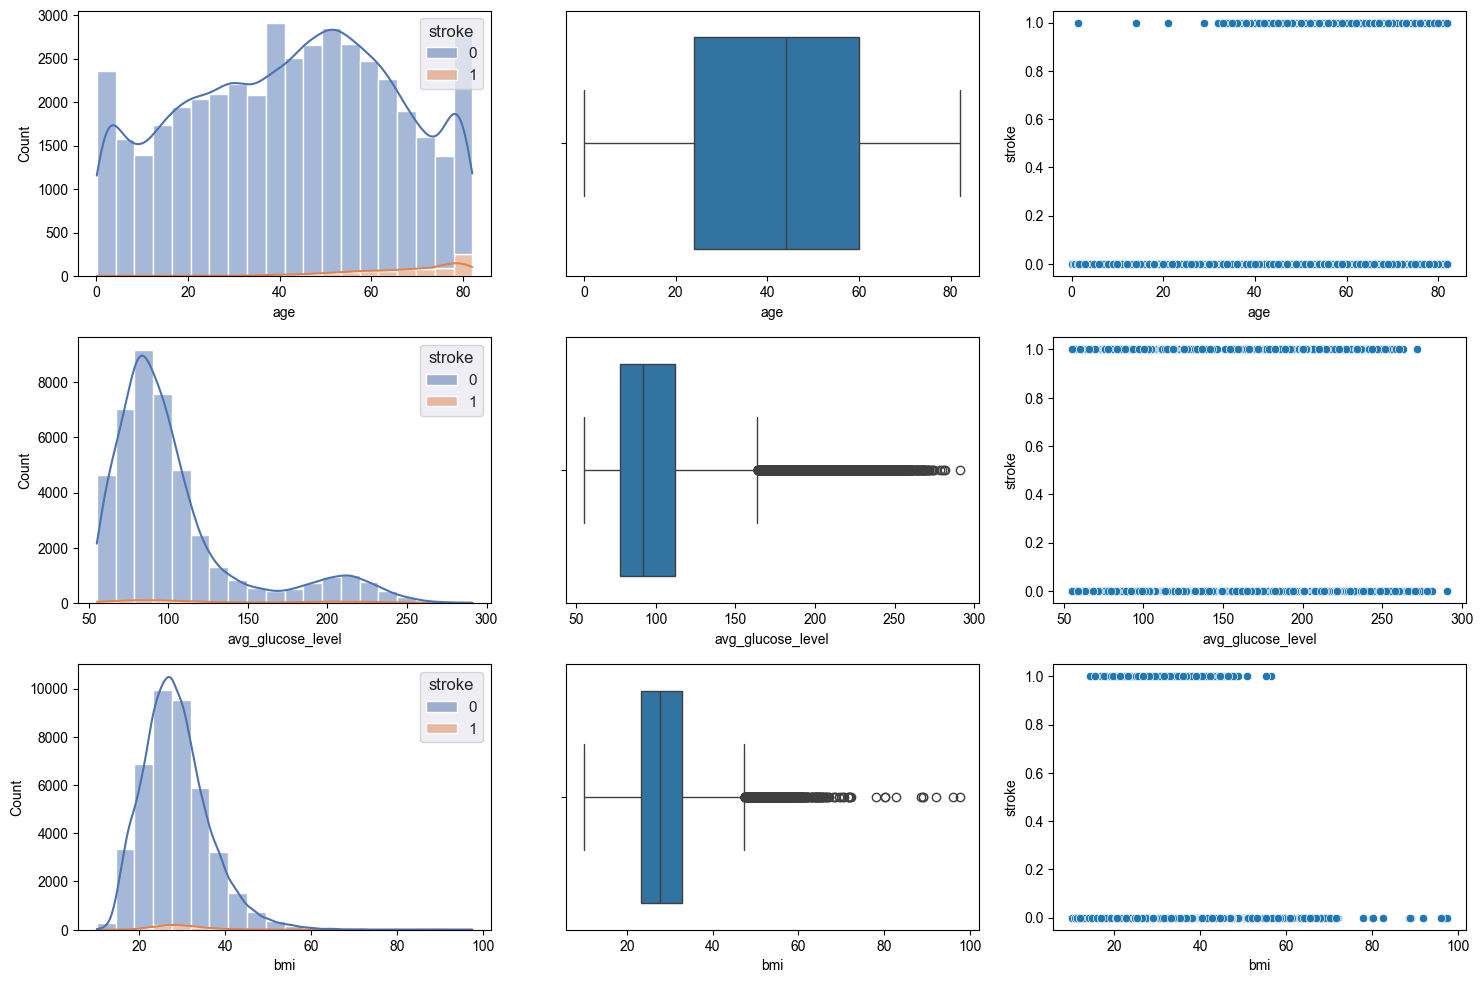

In [7]:
# plot numerical variables
def plot_num_var(numeric_cols):
    fig, axs = plt.subplots(3, 3, figsize=(15,10))
    sns.set_theme()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df, x=col, hue='stroke', kde=True, bins=20, multiple='stack', ax=axs[i, 0])
        sns.boxplot(df, x=col, ax=axs[i, 1])
        sns.scatterplot(df, x=col, y='stroke', ax=axs[i,2])
        
    plt.tight_layout()

plot_num_var(numeric_cols)

### Stroke by Categorical Variables

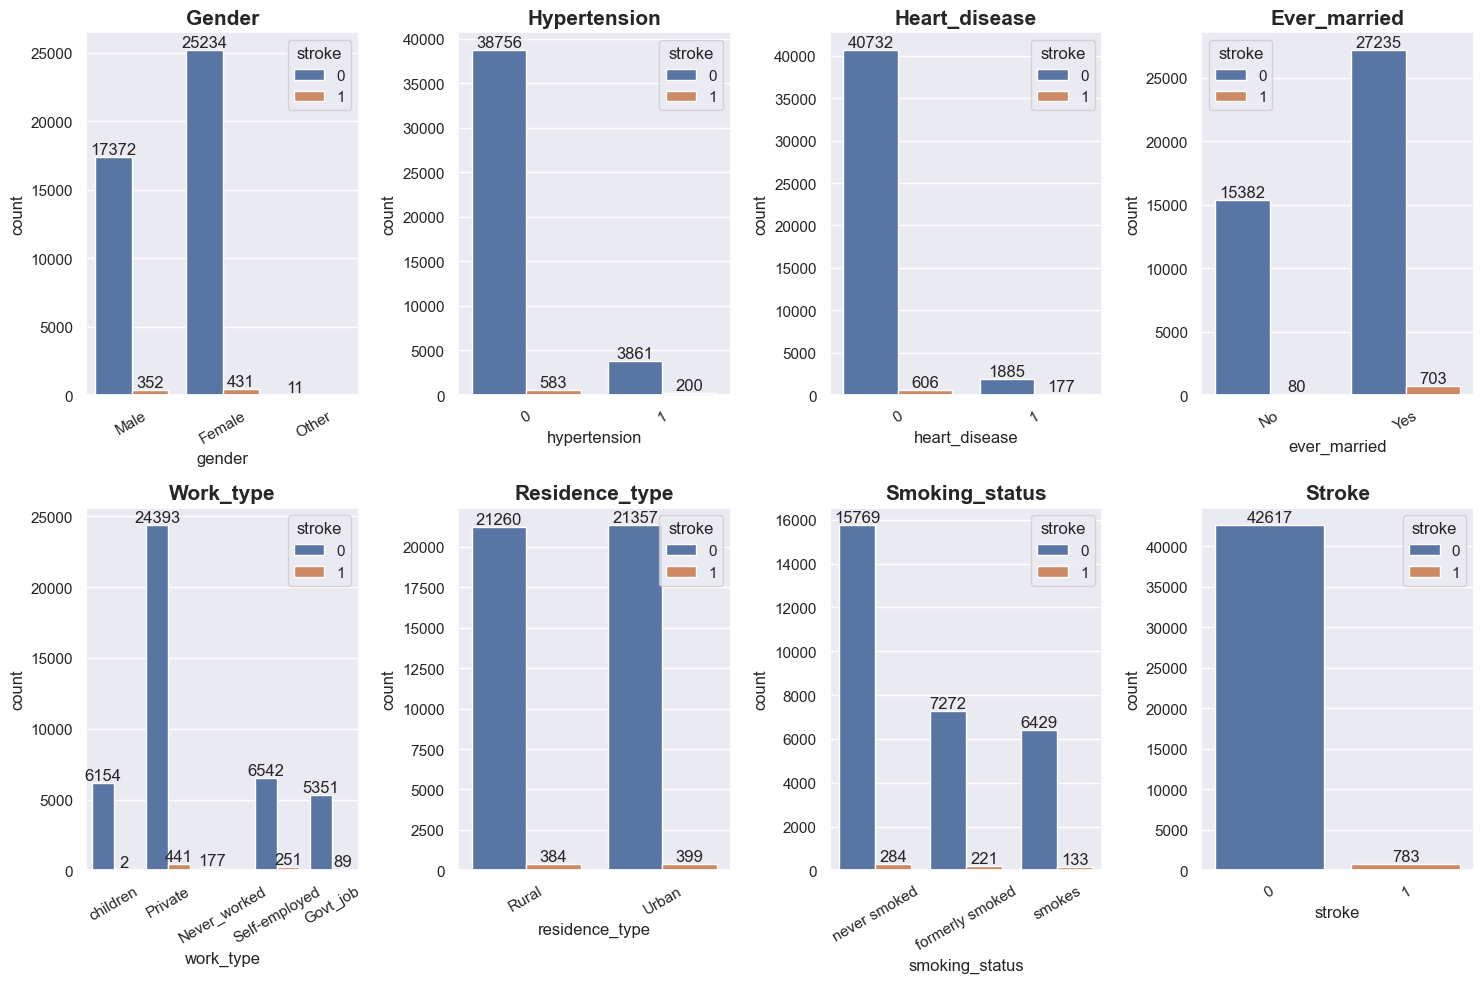

In [8]:
# plot categorical variables
def plot_cat_var(categorical_cols):
    fig, axs = plt.subplots(len(categorical_cols)//4, 4, figsize=(15, 10))

    for i, col in enumerate(categorical_cols):
        ax = sns.countplot(df, x=col, hue='stroke', ax=axs[i // 4, i % 4])
        ax.tick_params(axis='x', rotation=30)
        ax.set_title(col.capitalize(), weight='bold', fontsize=15)

        for container in ax.containers:
            ax.bar_label(container)

    plt.tight_layout()

plot_cat_var(categorical_cols)

## Modeling

### Data Preprocessing

In [9]:
#check for missing values
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [10]:
# check values in ['gender']
print(df['gender'].value_counts())

# drop 'Other' values in ['gender'] due to insufficient data
df = df[df['gender']!='Other']

df['gender'].value_counts()

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64


gender
Female    25665
Male      17724
Name: count, dtype: int64

count    41931.000000
mean        28.605156
std          7.770186
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: bmi, dtype: float64

median: 27.7


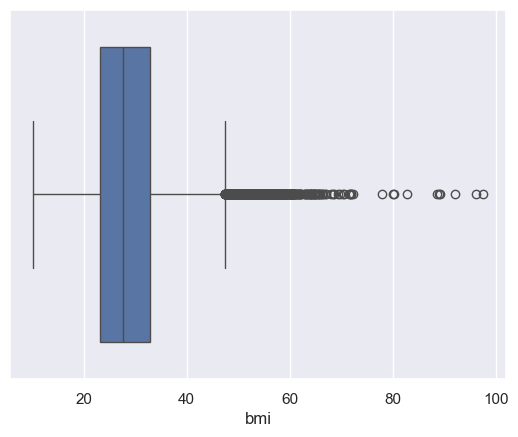

In [11]:
# visualization of ['bmi']
sns.boxplot(x=df['bmi'])
print(df['bmi'].describe())

# due to outliers, replace missing values with median
median = df['bmi'].median()
print(f'\nmedian: {median}')

In [12]:
# replace missing data in ['bmi'] with median
df['bmi'].fillna(median, inplace=True)

# reassign missing values of ['smoking_status'] as 'unknown' instead of dropping
df['smoking_status'].fillna('unknown', inplace=True)

df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
# categorize numerical variables based on criteria by Centers for Disease Control and Prevention
def categorize_num_var(df):
    # categorize ['avg_glucose_level']
    df['avg_glucose_level'] = pd.cut(x=df['avg_glucose_level'], 
                                     bins=[0, 100, 126, np.inf], 
                                     labels=['normal', 'prediabetic', 'diabetic'])
    # categorize ['bmi']
    df['bmi'] = pd.cut(x=df['bmi'],
                       bins=[0, 18.5, 25, 30, np.inf],
                       labels=['underweight', 'normal', 'overweight', 'obese'])
    
    return df
    
df = categorize_num_var(df)

# check unique values of categorical variables
for col in df.drop(['age'], axis=1):
    print(f'{col} : {df[col].unique()}')

gender : ['Male' 'Female']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
avg_glucose_level : ['normal', 'prediabetic', 'diabetic']
Categories (3, object): ['normal' < 'prediabetic' < 'diabetic']
bmi : ['underweight', 'obese', 'normal', 'overweight']
Categories (4, object): ['underweight' < 'normal' < 'overweight' < 'obese']
smoking_status : ['unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [14]:
# change data into adequate data types
for col in df.drop('age', axis=1):
    df[col] = df[col].astype('category')
        
df['age'] = df['age'].astype('int')
df.dtypes

gender               category
age                     int64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
residence_type       category
avg_glucose_level    category
bmi                  category
smoking_status       category
stroke               category
dtype: object

### Modeling - Without Resampling

In [15]:
# differentiate feature variables & target variable
X = df.drop('stroke', axis=1)
y = df['stroke']


"""It is important to split data before resampling to retain original data distribution.
Resampling to adjust data imbalance is only applied to the train data to improve the accuracy of ML models, not the test data."""
# split train & validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0, stratify=y)

print(f"Train dataset - {y_train.value_counts()}", 
      f"Test dataset - {y_test.value_counts()}", 
      '-'*50,
      f"Train dataset (%) - {y_train.value_counts(normalize=True)*100}", 
      f"Test dataset (%) - {y_test.value_counts(normalize=True)*100}", sep='\n\n')

Train dataset - stroke
0    31954
1      587
Name: count, dtype: int64

Test dataset - stroke
0    10652
1      196
Name: count, dtype: int64

--------------------------------------------------

Train dataset (%) - stroke
0    98.196122
1     1.803878
Name: proportion, dtype: float64

Test dataset (%) - stroke
0    98.193215
1     1.806785
Name: proportion, dtype: float64


In [16]:
# scale & encode variables accordingly
transformer = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['age']),
        ('cat', OrdinalEncoder(), X_train.columns.drop('age'))
    ],
    remainder='passthrough'
)

X_train_transformed = pd.DataFrame(transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())
X_test_transformed = pd.DataFrame(transformer.transform(X_test), columns=transformer.get_feature_names_out()) 

X_train_transformed.head()

,num__age,cat__gender,cat__hypertension,cat__heart_disease,cat__ever_married,cat__work_type,cat__residence_type,cat__avg_glucose_level,cat__bmi,cat__smoking_status
0,0.865854,0.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0
1,0.951220,1.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0
2,0.621951,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0
3,0.439024,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0
4,0.963415,1.0,0.0,0.0,1.0,3.0,1.0,0.0,2.0,1.0


In [17]:
# models and hyperparameters for GridSearchCV
models = {
    "LogisticRegression": {
        'model': LogisticRegression(random_state=0),
        'param grid': {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.1, 1, 10, 100],
            'solver': ['lbfgs', 'saga']
        }
    },
    "DecisionTree": {
        'model': DecisionTreeClassifier(random_state=0),
        'param grid': {
            'criterion': ['gini', 'log_loss'],
            'max_depth': [2, 5, 10, 20]
        }
    },
    "RandomForest": {
        'model': RandomForestClassifier(random_state=0, n_jobs=-1),
        'param grid': {
            'n_estimators': [50, 100, 200, 1000],
            'criterion': ['gini', 'log_loss'],
            'max_depth': [2, 5, 10, 20]
        }
    },
    "XGBoost": {
        'model': XGBClassifier(random_state=0, n_jobs=-1),
        'param grid': {
            'max_depth': [2, 5, 10, 20],
            'learning_rate': [0.1, 0.01, 0.001],
            'n_estimators': [50, 100, 200, 1000]
        }
    },
    "AdaBoost": {
        'model': AdaBoostClassifier(random_state=0),
        'param grid': {
            'learning_rate': [0.1, 0.5, 1],
            'n_estimators': [50, 100, 200, 1000]
        }
    },
    "GaussianNB": {
        'model': GaussianNB()
    }
}

In [18]:
def train_models(X, y):
    for model_name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info.get('param grid')

        # perform grid search if param_grid is present
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc')
            grid_search.fit(X, y)

            # save results
            model_info['best params'] = grid_search.best_params_
            model_info['best score'] = grid_search.best_score_
            model_info['best estimator'] = grid_search.best_estimator_

            print(f"{model_info['best estimator']}\n{model_name} trained.\n")
        
        else:
            model.fit(X, y)
            print(f"{model_name} trained.")

train_models(X_train_transformed, y_train)

LogisticRegression(C=1, random_state=0, solver='saga')
LogisticRegression trained.

DecisionTreeClassifier(criterion='log_loss', max_depth=5, random_state=0)
DecisionTree trained.

RandomForestClassifier(criterion='log_loss', max_depth=5, n_estimators=1000,
                       n_jobs=-1, random_state=0)
RandomForest trained.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estima

--------------------------------------------------------------------------------

Model Performance - LogisticRegression

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10652
           1       0.00      0.00      0.00       196

    accuracy                           0.98     10848
   macro avg       0.49      0.50      0.50     10848
weighted avg       0.96      0.98      0.97     10848



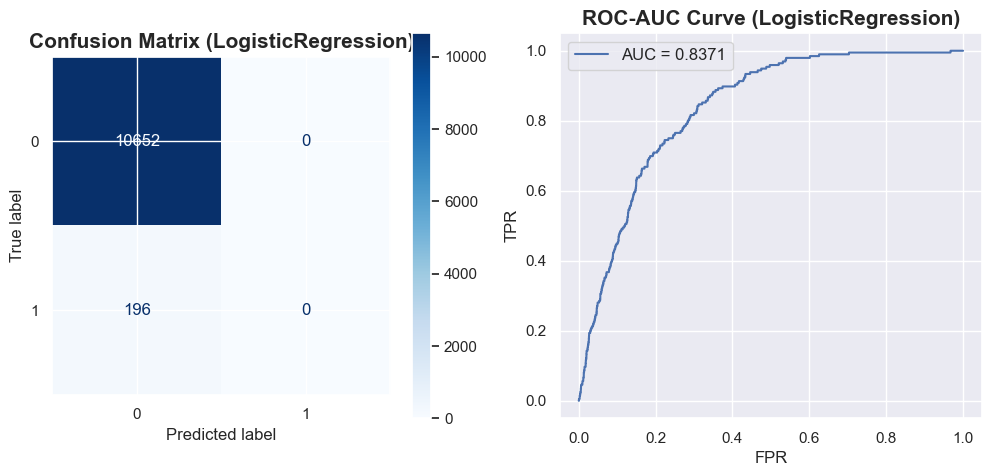

--------------------------------------------------------------------------------

Model Performance - DecisionTree

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10652
           1       0.00      0.00      0.00       196

    accuracy                           0.98     10848
   macro avg       0.49      0.50      0.50     10848
weighted avg       0.96      0.98      0.97     10848



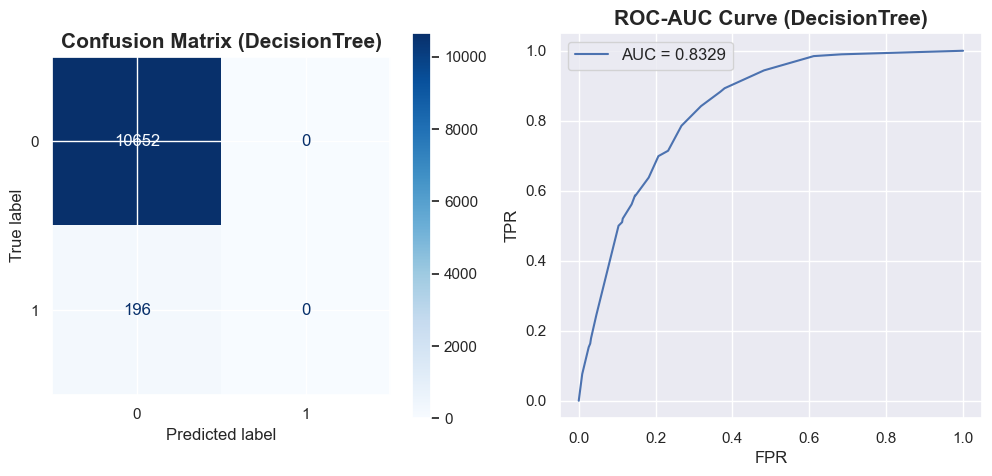

--------------------------------------------------------------------------------

Model Performance - RandomForest

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10652
           1       0.00      0.00      0.00       196

    accuracy                           0.98     10848
   macro avg       0.49      0.50      0.50     10848
weighted avg       0.96      0.98      0.97     10848



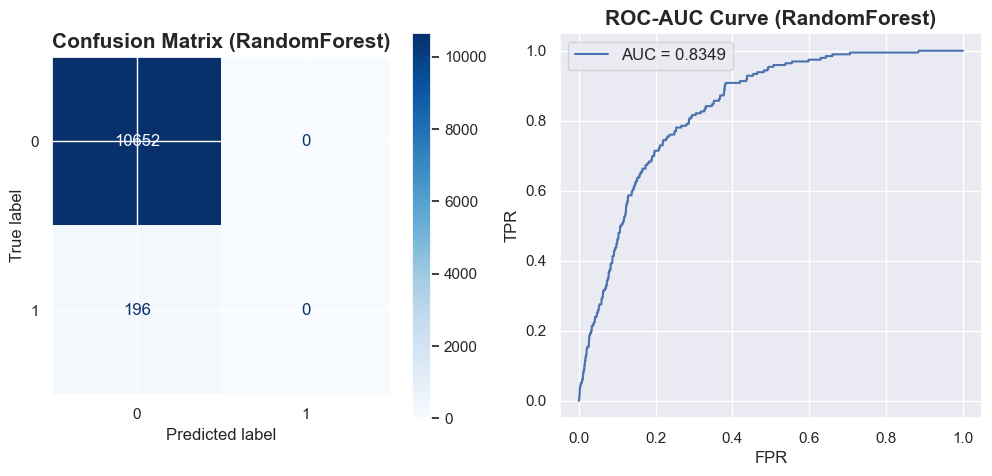

--------------------------------------------------------------------------------

Model Performance - XGBoost

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10652
           1       0.00      0.00      0.00       196

    accuracy                           0.98     10848
   macro avg       0.49      0.50      0.50     10848
weighted avg       0.96      0.98      0.97     10848



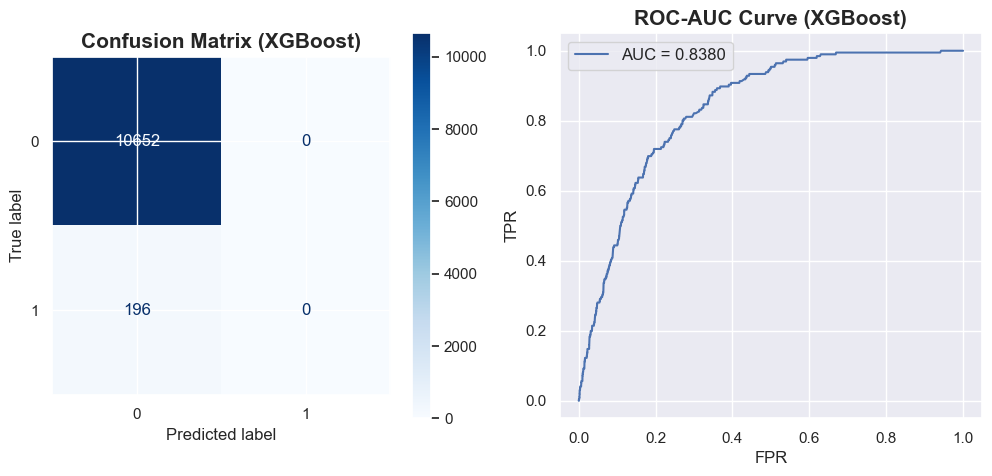

--------------------------------------------------------------------------------

Model Performance - AdaBoost

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10652
           1       0.00      0.00      0.00       196

    accuracy                           0.98     10848
   macro avg       0.49      0.50      0.50     10848
weighted avg       0.96      0.98      0.97     10848



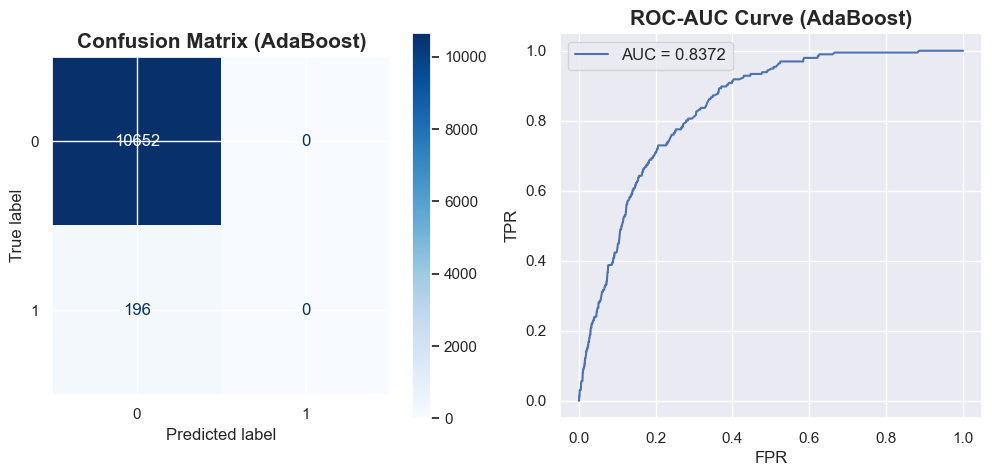

--------------------------------------------------------------------------------

Model Performance - GaussianNB

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     10652
           1       0.07      0.32      0.11       196

    accuracy                           0.91     10848
   macro avg       0.53      0.62      0.53     10848
weighted avg       0.97      0.91      0.94     10848



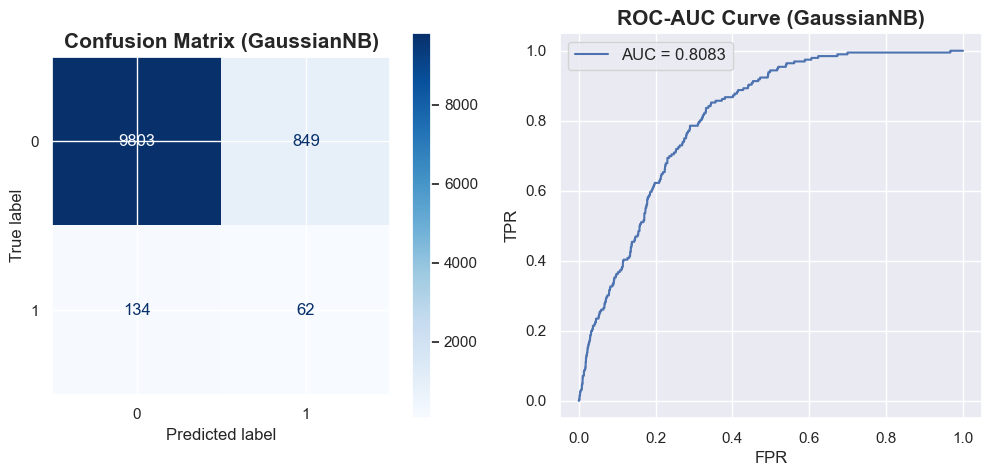

In [19]:
def display_results(models):
    for model_name, model_info in models.items():
        # recall model with best combination of hyperparameters
        if 'best estimator' in model_info:
            model = model_info['best estimator']
        else:
            model = model_info['model']
        
        y_pred = model.predict(X_test_transformed)
        y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

        # roc_auc_score
        auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)

        #classifcation report
        print('-' * 80,
              f"Model Performance - {model_name}",
              classification_report(y_test, y_pred, zero_division=0),
              sep='\n\n')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

        # plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=ax1)
        ax1.set_title(f"Confusion Matrix ({model_name})", fontsize=15, weight='bold')

        # plot ROC-AUC curve
        ax2.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
        ax2.legend(fontsize='medium')
        ax2.set_title(f"ROC-AUC Curve ({model_name})", fontsize=15, weight='bold')
        ax2.set_xlabel('FPR')
        ax2.set_ylabel('TPR')
        plt.show()

display_results(models)

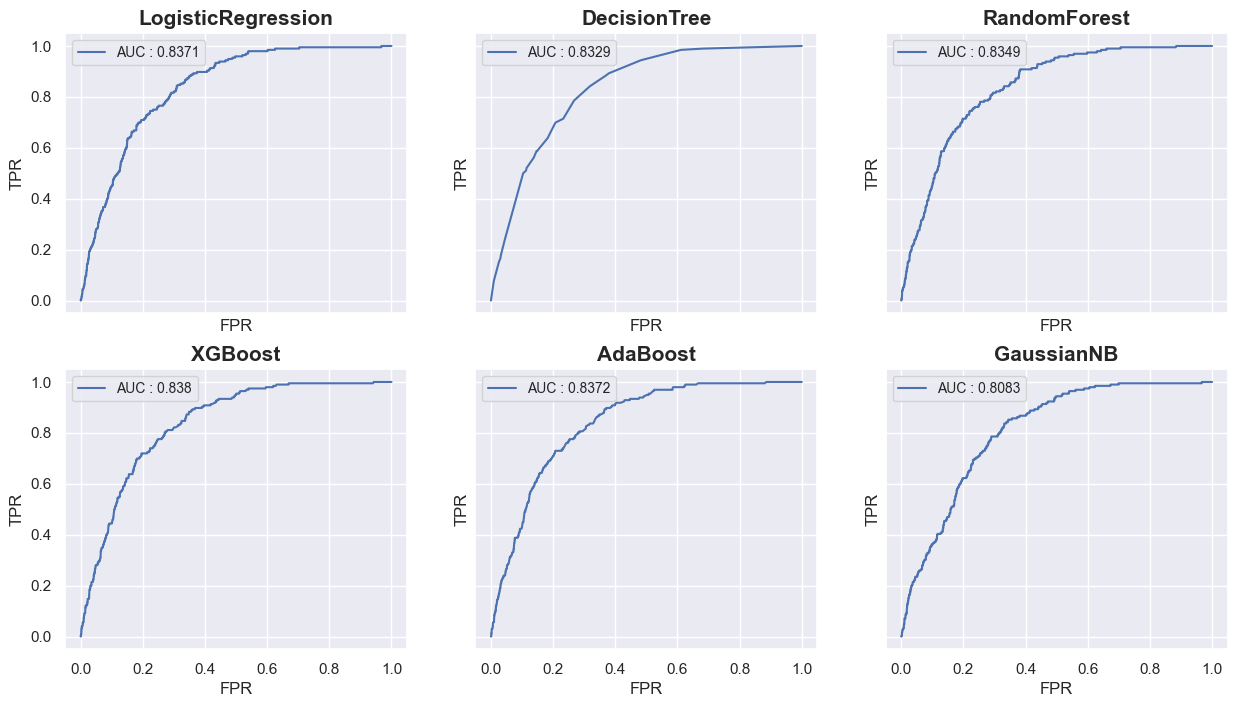

<Figure size 640x480 with 0 Axes>

In [20]:
def plot_roc_auc_curves(models):
    fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True, sharey=True)
    sns.set_theme()

    # plot ROC-AUC curve
    for i, (model_name, model_info) in enumerate(models.items()):
        if 'best estimator' in model_info:
            model = model_info['best estimator']
        else:
            model = model_info['model']

        y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
        fpr, tpr, threshholds = roc_curve(y_test, y_pred_proba)
        auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)

        ax = axs[i//3, i%3]
        ax.plot(fpr, tpr, label=f"AUC : {auc_score}")
        ax.legend(loc='upper left', fontsize='small')
        ax.set_title(model_name, fontsize=15, weight='bold')

    for ax in axs.flat:
        ax.set(xlabel='FPR', ylabel='TPR')

    plt.show()
    plt.tight_layout()

plot_roc_auc_curves(models)

In [21]:
def create_df_results(models):
    names = []
    auc_scores = []
    f1scores_macro = []
    recall_macro = []
    precision_macro = []

    for model_name, model_info in models.items():
        if 'best estimator' in model_info:
            model = model_info['best estimator']
        else:
            model = model_info['model']

        y_pred = model.predict(X_test_transformed)
        y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]

        #roc_auc_score
        auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)
        
        # save values in lists
        clf_report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        macro_avg = clf_report['macro avg']
        names.append(model_name)
        auc_scores.append(auc_score)
        f1scores_macro.append(round(macro_avg['f1-score'], 4))
        recall_macro.append(round(macro_avg['recall'], 4))
        precision_macro.append(round(macro_avg['precision'], 4))

    # create dataframe to show results
    df = pd.DataFrame({
        'model': names,
        'auc score': auc_scores,
        'recall': recall_macro,
        'f1 score': f1scores_macro,
        'precision': precision_macro
        })

    df.sort_values(by=['auc score', 'recall', 'f1 score'], inplace=True, ignore_index=True, ascending=False)

    return df

df_res = create_df_results(models)
df_res

,model,auc score,recall,f1 score,precision
0,XGBoost,0.8380,0.5000,0.4954,0.4910
1,AdaBoost,0.8372,0.5000,0.4954,0.4910
2,LogisticRegression,0.8371,0.5000,0.4954,0.4910
3,RandomForest,0.8349,0.5000,0.4954,0.4910
4,DecisionTree,0.8329,0.5000,0.4954,0.4910
5,GaussianNB,0.8083,0.6183,0.5321,0.5273


**Results**
* Used macro avg scores as it is importance to classify both positives and negatives correctly
* The models scored decently on roc-auc score but poorly on f1 score, recall, and precision
* The models did not predict true positives correctly, and only GaussianNB partially predicted true positives correctly.

### Modeling - Oversampling (SMOTE)

In [22]:
# oversampling using SMOTE
X_train_smote, y_train_smote = SMOTE(random_state=0).fit_resample(X_train_transformed, y_train)

print(y_train.value_counts(),
      f"After Resampling (SMOTE):\n{y_train_smote.value_counts()}", 
      sep="\n\n")

stroke
0    31954
1      587
Name: count, dtype: int64

After Resampling (SMOTE):
stroke
0    31954
1    31954
Name: count, dtype: int64


In [23]:
train_models(X_train_smote, y_train_smote)

LogisticRegression(C=0.1, random_state=0, solver='saga')
LogisticRegression trained.

DecisionTreeClassifier(criterion='log_loss', max_depth=20, random_state=0)
DecisionTree trained.

RandomForestClassifier(max_depth=20, n_estimators=1000, n_jobs=-1,
                       random_state=0)
RandomForest trained.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs

--------------------------------------------------------------------------------

Model Performance - LogisticRegression

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     10652
           1       0.05      0.77      0.10       196

    accuracy                           0.74     10848
   macro avg       0.52      0.76      0.47     10848
weighted avg       0.98      0.74      0.84     10848



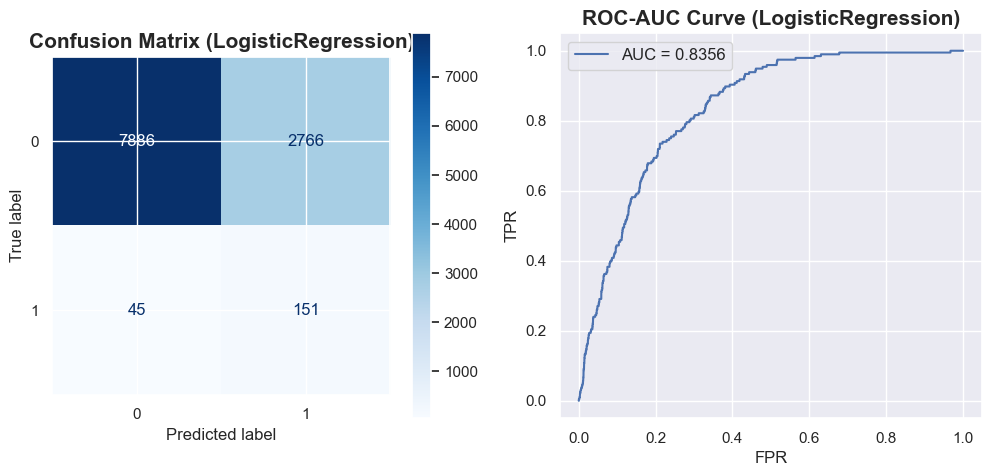

--------------------------------------------------------------------------------

Model Performance - DecisionTree

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     10652
           1       0.08      0.34      0.13       196

    accuracy                           0.92     10848
   macro avg       0.54      0.63      0.55     10848
weighted avg       0.97      0.92      0.94     10848



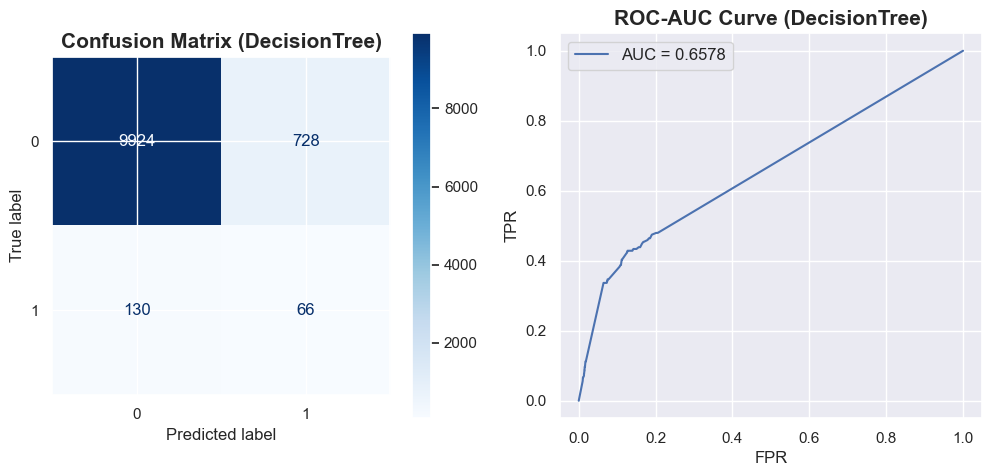

--------------------------------------------------------------------------------

Model Performance - RandomForest

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10652
           1       0.03      0.06      0.04       196

    accuracy                           0.95     10848
   macro avg       0.51      0.51      0.51     10848
weighted avg       0.97      0.95      0.96     10848



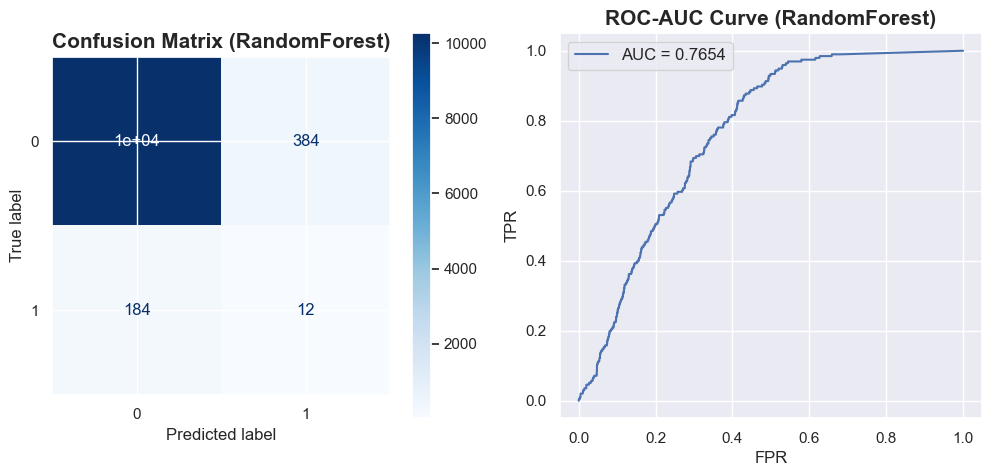

--------------------------------------------------------------------------------

Model Performance - XGBoost

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10652
           1       0.04      0.05      0.04       196

    accuracy                           0.96     10848
   macro avg       0.51      0.51      0.51     10848
weighted avg       0.97      0.96      0.96     10848



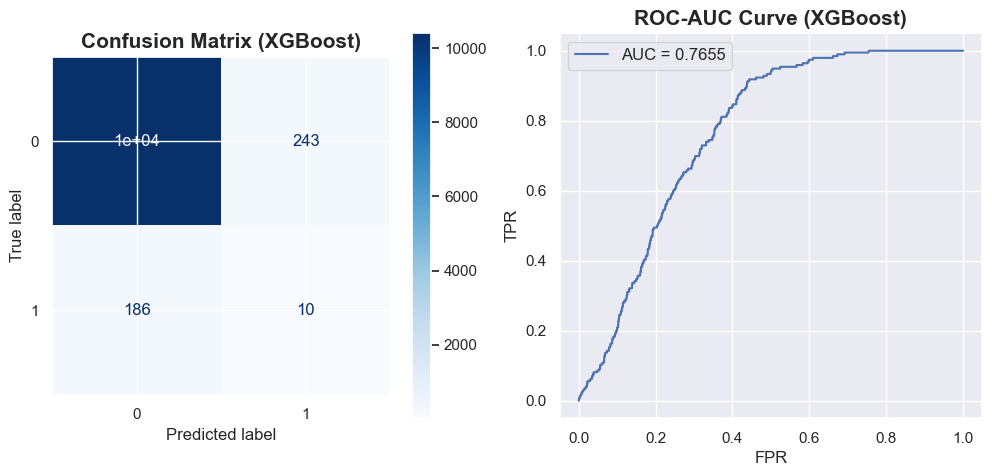

--------------------------------------------------------------------------------

Model Performance - AdaBoost

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     10652
           1       0.06      0.12      0.08       196

    accuracy                           0.95     10848
   macro avg       0.52      0.54      0.53     10848
weighted avg       0.97      0.95      0.96     10848



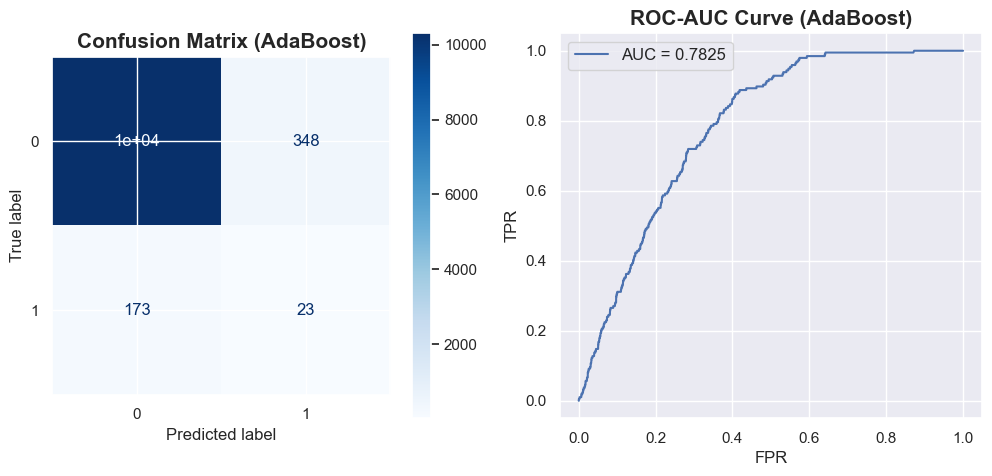

--------------------------------------------------------------------------------

Model Performance - GaussianNB

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     10652
           1       0.05      0.78      0.09       196

    accuracy                           0.70     10848
   macro avg       0.52      0.74      0.45     10848
weighted avg       0.98      0.70      0.81     10848



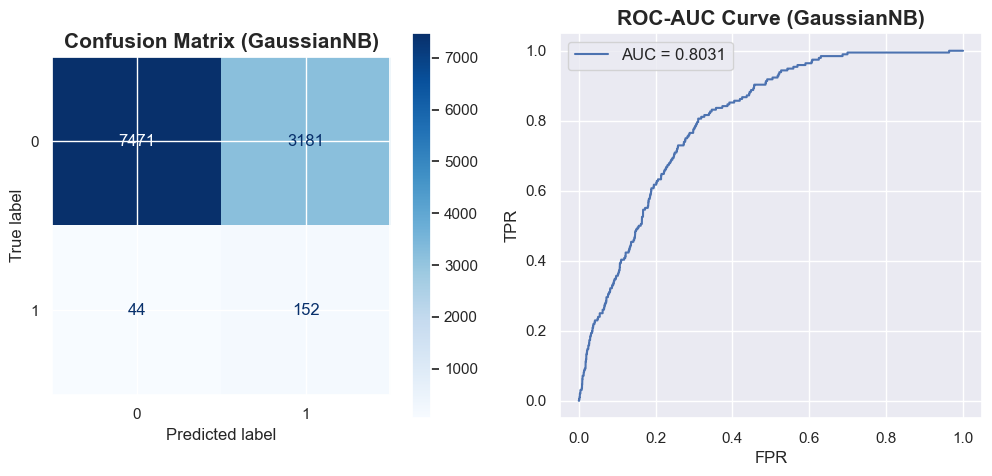

In [24]:
display_results(models)

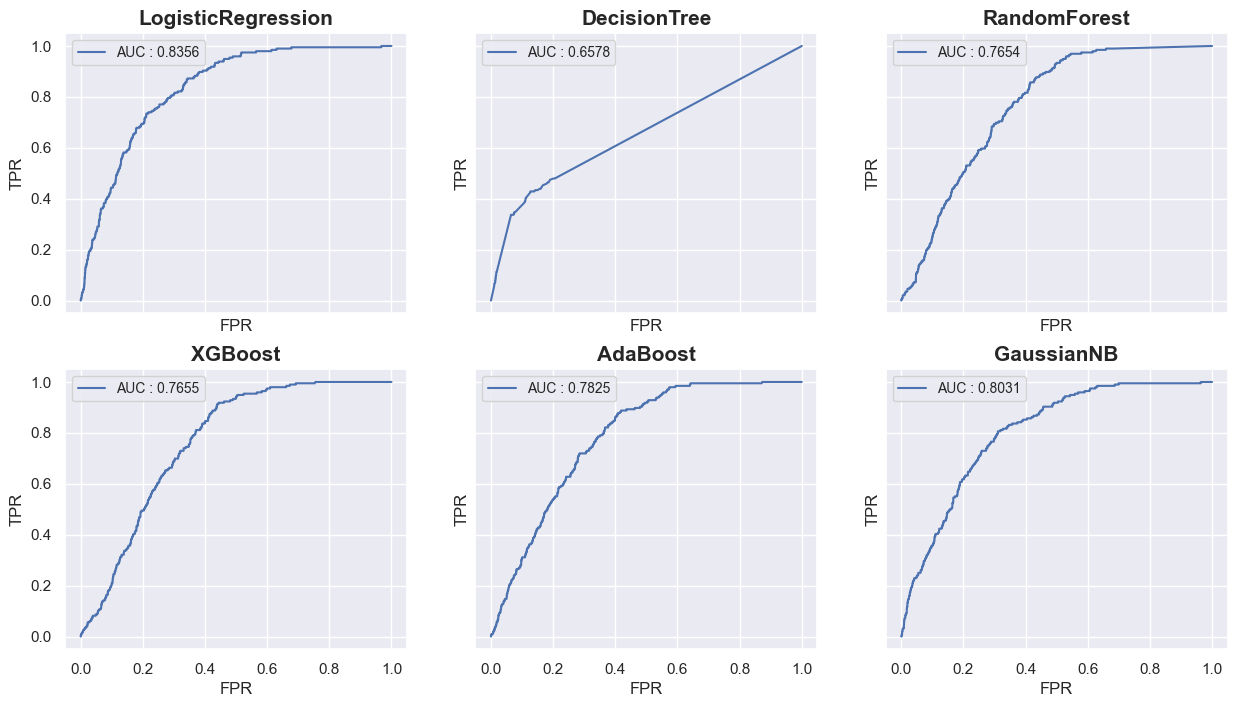

<Figure size 640x480 with 0 Axes>

In [25]:
plot_roc_auc_curves(models)

In [26]:
df_res_smote = create_df_results(models)
df_res_smote

,model,auc score,recall,f1 score,precision
0,LogisticRegression,0.8356,0.7554,0.4729,0.5230
1,GaussianNB,0.8031,0.7384,0.4543,0.5199
2,AdaBoost,0.7825,0.5423,0.5282,0.5227
3,XGBoost,0.7655,0.5141,0.5122,0.5110
4,RandomForest,0.7654,0.5126,0.5068,0.5063
5,DecisionTree,0.6578,0.6342,0.5459,0.5351


**Results**
* Resampling train data generally decreased the models' roc-auc scores but increased recall scores.
* Logistic Regression and GaussianNB performed considerably better than others.

### Modeling - Oversampling + Undersampling (SMOTEENN)

In [27]:
# oversampling + undersampling using SMOTEENN
X_train_smoteenn, y_train_smoteenn = SMOTEENN(random_state=0).fit_resample(X_train_transformed, y_train)

print(y_train.value_counts(), 
      f"After Resampling (SMOTEENN):\n{y_train_smoteenn.value_counts()}", 
      sep="\n\n")

stroke
0    31954
1      587
Name: count, dtype: int64

After Resampling (SMOTEENN):
stroke
0    29392
1    28417
Name: count, dtype: int64


In [28]:
train_models(X_train_smoteenn, y_train_smoteenn)

LogisticRegression(C=0.1, random_state=0)
LogisticRegression trained.

DecisionTreeClassifier(criterion='log_loss', max_depth=20, random_state=0)
DecisionTree trained.

RandomForestClassifier(max_depth=20, n_estimators=1000, n_jobs=-1,
                       random_state=0)
RandomForest trained.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
            

--------------------------------------------------------------------------------

Model Performance - LogisticRegression

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     10652
           1       0.05      0.77      0.10       196

    accuracy                           0.74     10848
   macro avg       0.52      0.76      0.47     10848
weighted avg       0.98      0.74      0.84     10848



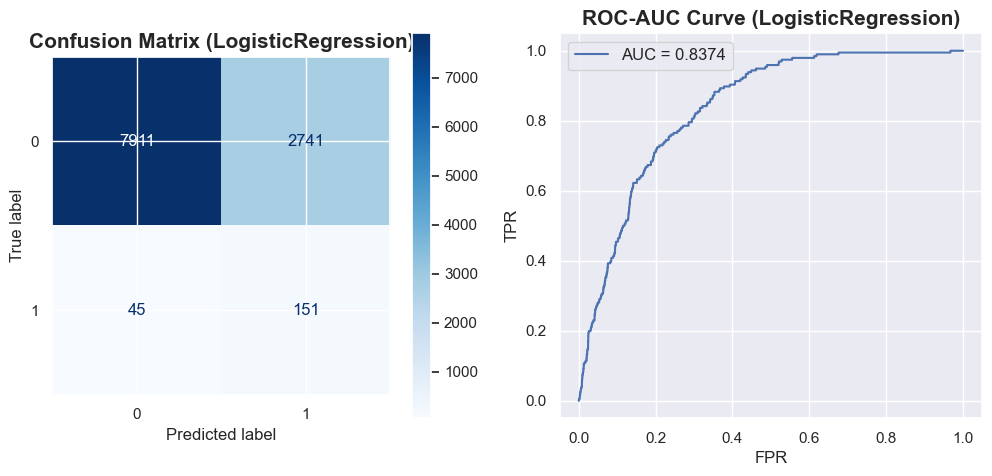

--------------------------------------------------------------------------------

Model Performance - DecisionTree

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10652
           1       0.06      0.17      0.08       196

    accuracy                           0.93     10848
   macro avg       0.52      0.56      0.52     10848
weighted avg       0.97      0.93      0.95     10848



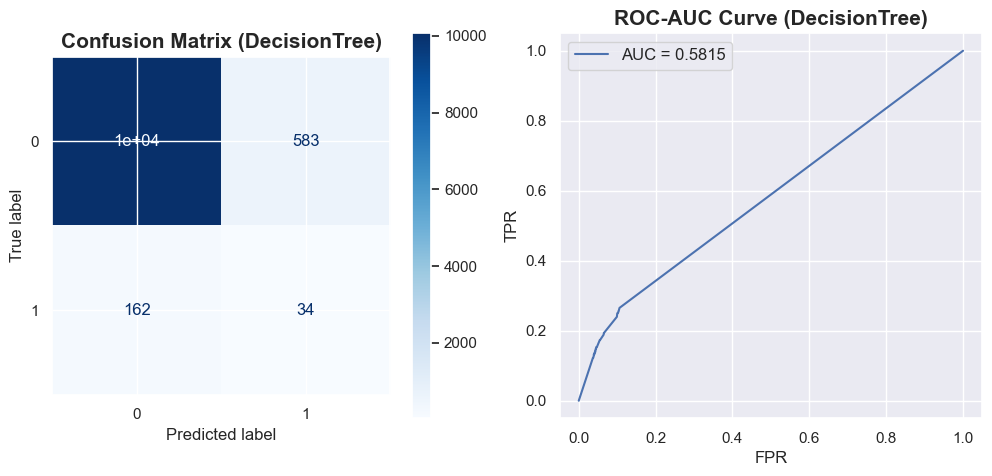

--------------------------------------------------------------------------------

Model Performance - RandomForest

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10652
           1       0.05      0.12      0.07       196

    accuracy                           0.94     10848
   macro avg       0.52      0.54      0.52     10848
weighted avg       0.97      0.94      0.95     10848



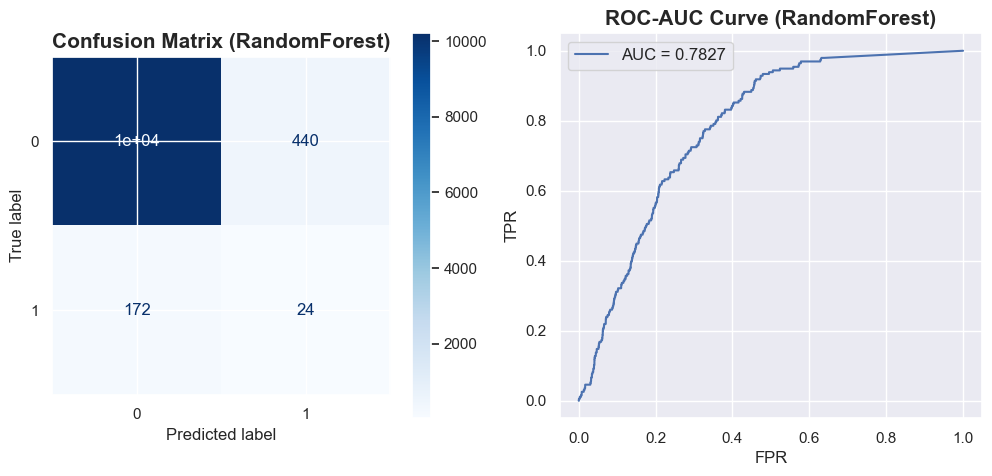

--------------------------------------------------------------------------------

Model Performance - XGBoost

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10652
           1       0.04      0.10      0.06       196

    accuracy                           0.94     10848
   macro avg       0.51      0.53      0.51     10848
weighted avg       0.97      0.94      0.95     10848



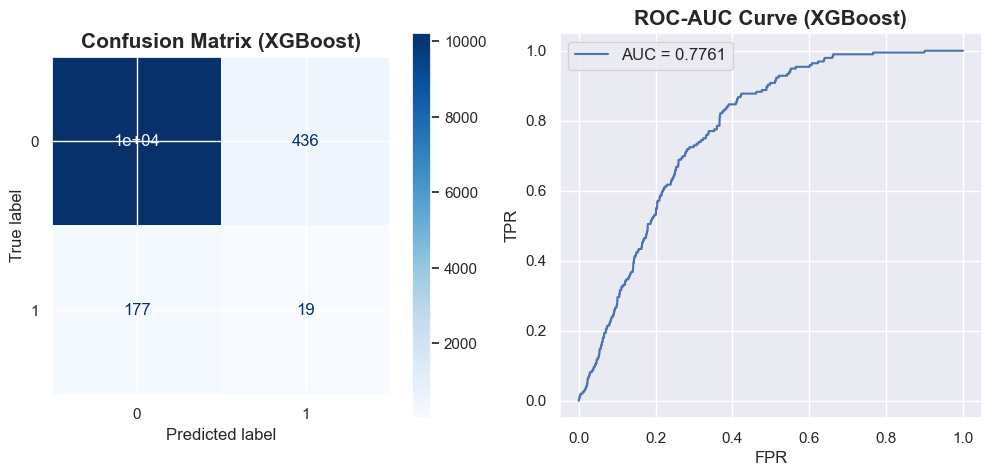

--------------------------------------------------------------------------------

Model Performance - AdaBoost

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10652
           1       0.07      0.09      0.08       196

    accuracy                           0.96     10848
   macro avg       0.53      0.53      0.53     10848
weighted avg       0.97      0.96      0.96     10848



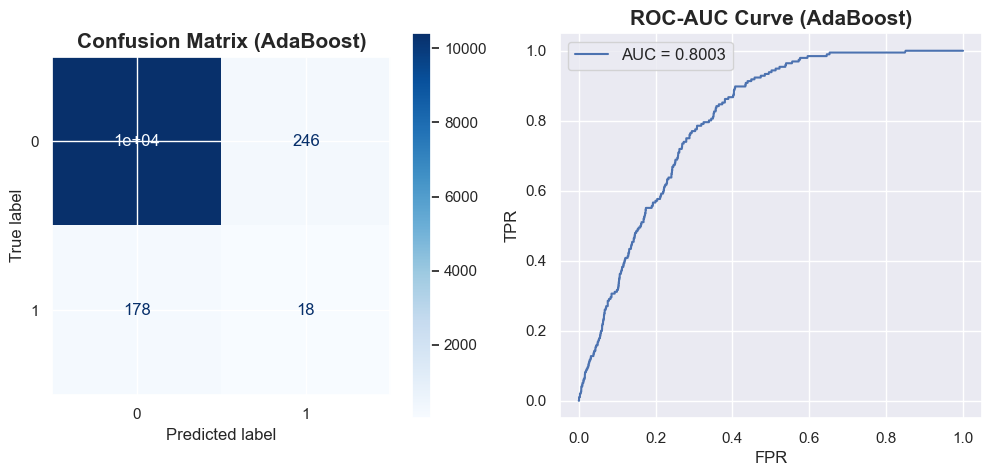

--------------------------------------------------------------------------------

Model Performance - GaussianNB

              precision    recall  f1-score   support

           0       0.99      0.72      0.84     10652
           1       0.05      0.75      0.09       196

    accuracy                           0.72     10848
   macro avg       0.52      0.74      0.46     10848
weighted avg       0.98      0.72      0.82     10848



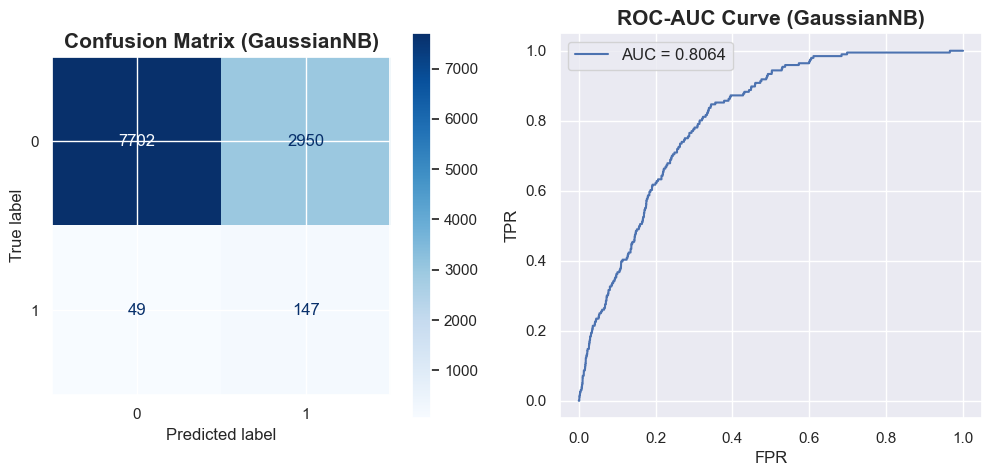

In [29]:
display_results(models)

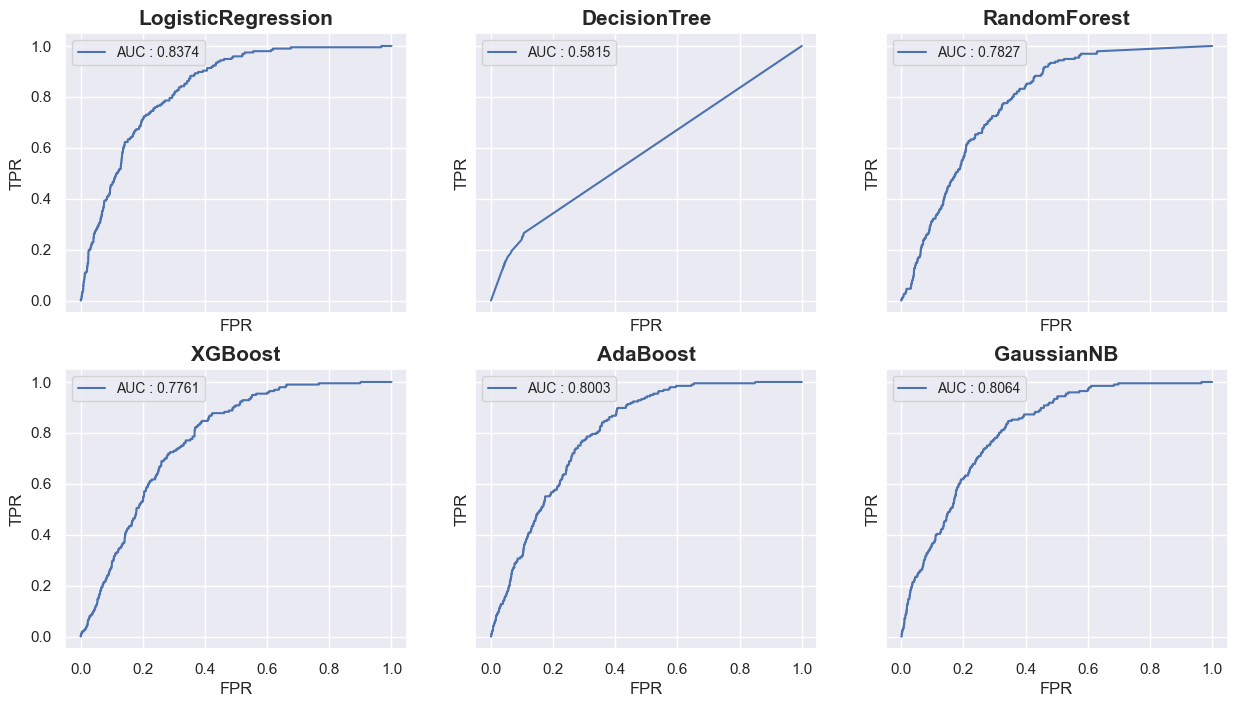

<Figure size 640x480 with 0 Axes>

In [30]:
plot_roc_auc_curves(models)

In [31]:
df_res_smoteenn = create_df_results(models)
df_res_smoteenn

,model,auc score,recall,f1 score,precision
0,LogisticRegression,0.8374,0.7565,0.4740,0.5233
1,GaussianNB,0.8064,0.7365,0.4632,0.5206
2,AdaBoost,0.8003,0.5344,0.5291,0.5257
3,RandomForest,0.7827,0.5406,0.5218,0.5176
4,XGBoost,0.7761,0.5280,0.5146,0.5124
5,DecisionTree,0.5815,0.5594,0.5240,0.5196


**Results**
* Similar to SMOTE, ROC-AUC scores decreased but recall scores increased.
* Again, LogisticRegression and GaussianNB performed considerably well compared to others.

In [32]:
# differentiate results by renaming models
df_res_smote['model'] = [name + ' (SMOTE)' for name in df_res_smote['model']]
df_res_smoteenn['model'] = [name + ' (SMOTEENN)' for name in df_res_smoteenn['model']]

# concatenate dataframes
df_res_overall = pd.concat([df_res, df_res_smote, df_res_smoteenn])

In [33]:
df_res_overall.sort_values(by=['recall'], inplace=True, ignore_index=True, ascending=False)
df_res_overall

,model,auc score,recall,f1 score,precision
0,LogisticRegression (SMOTEENN),0.8374,0.7565,0.4740,0.5233
1,LogisticRegression (SMOTE),0.8356,0.7554,0.4729,0.5230
2,GaussianNB (SMOTE),0.8031,0.7384,0.4543,0.5199
3,GaussianNB (SMOTEENN),0.8064,0.7365,0.4632,0.5206
4,DecisionTree (SMOTE),0.6578,0.6342,0.5459,0.5351
5,GaussianNB,0.8083,0.6183,0.5321,0.5273
6,DecisionTree (SMOTEENN),0.5815,0.5594,0.5240,0.5196
7,AdaBoost (SMOTE),0.7825,0.5423,0.5282,0.5227
8,RandomForest (SMOTEENN),0.7827,0.5406,0.5218,0.5176
9,AdaBoost (SMOTEENN),0.8003,0.5344,0.5291,0.5257
